In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math
from functools import partial

import bases
import eigensolvers
import functionals
import generators
import representations
import reconstructions
import utils

In [2]:
class TestEigenfunc:
    def __init__(self, *args, **kwargs):
        self.frequency = kwargs.get('frequency', np.sqrt(2)/10)
        self.initial_state = kwargs.get('initial_state', 0)
        self.degree = kwargs.get('degree', 5)
        self.num_col = kwargs.get('num_col', 1000)
        self.representation_func = representations.mpEDMD_matrix_representation
    
    def get_true_eigenfunction(self, eigenvalue):
        """
        For the the frequency w, and the eigenvalue np.exp(1j*2*pi*n*w),
        the corresponding eigenfunction should be phi(x) = np.exp(1j*2*pi*n*x).
        """
        ev_angle = np.angle(eigenvalue)  # should be 2*pi*n*w
        ef_angle = ev_angle / self.frequency  # should be 2*pi*n
        ef = lambda x: np.exp(1j * ef_angle * x)  # should be phi(x) = np.exp(1j*2*pi*n*x)
        return ef
    
    def get_power_vector_with_true_eigenfunction(self, eigenvalues, basis):
        r = eigenvalues.shape[0]
        V = np.empty((r, r))
        for i in range(r):
            true_eigenfunction = self.get_true_eigenfunction(eigenvalues[i])
            p_vec = functionals.functional_inner_product(true_eigenfunction, basis, -np.pi, np.pi, input_size=1)
            V[:,i] = p_vec
        return V
    
    def get_settings(self):
        Yr, Xr = utils.generate_krylov(partial(generators.angle_evolution, alpha=self.frequency), generators.unit_circle_observable_function, self.initial_state, self.num_col)
        utils.plot_complex_on_unit_circle(Yr)
        basis = partial(bases.fourier_basis, degree=self.degree, combinations=True)
        return Xr, basis
    
    def plot_eigenfunctions(self, domain, N, n_row, n_col, mp_ef_val, new_ef_val, tr_ef_val, pow_ef_val):
        fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(16*n_col, 3*n_row))
        labels = ['mpEDMD', 'QR+EIG', 'QR+Power', 'True']
        for idx in range(N):
            if n_col==1:
                ax = axs[idx]
            else:
                i = idx//n_col
                j = idx%n_col
                ax = axs[i, j]
            ax.plot(domain, mp_ef_val[:,idx].real, 'b-.')
            ax.plot(domain, new_ef_val[:,idx].real, 'r--')
            ax.plot(domain, pow_ef_val[:,idx].real, 'm:')
            ax.plot(domain, tr_ef_val[:,idx].real, 'g-')
            ax.legend(labels)
        plt.show()

    def compare_on_unit_circle(self, val1, val2, val3, val4, n_row=3, N_max=20):
        n_col = 4
        fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))
        # fig.suptitle("eigenfunction value evolution")
        col_names = ['mpEDMD', 'True', 'QR+EIG', 'QR+Power']
        for c, name in enumerate(col_names):
            axs[0, c].set_title(name)
        for i in range(n_row):
            utils.set_subplot_complex_on_unit_circle(val1[:N_max,i], axs[i, 0], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val2[:N_max,i], axs[i, 1], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val3[:N_max,i], axs[i, 2], add_color=True)
            utils.set_subplot_complex_on_unit_circle(val4[:N_max,i], axs[i, 3], add_color=True)
        plt.show()

    def show_orthogonality_heatmap(self, V, L, vmin=0, vmax=None, title='Title'):
        df = pd.DataFrame(abs(V@V.T.conj()), index=L, columns=L)
        fig, ax = plt.subplots(figsize=(16,12))
        ax.set_title(title)
        sns.heatmap(df, vmin=vmin, vmax=vmax, linewidth=0.5, ax=ax, annot=True, fmt='.2f')
        plt.show()
        return

    def run(self):
        Xr, basis = self.get_settings()
        K, V, L = self.representation_func(Xr, basis=basis)
        # eigenvalues, true_V, n = eigensolvers.QR_algorithm_with_inverse_iteration(K)
        # eigenvalues, power_V, n = eigensolvers.QR_algorithm_with_power_vector(K, basis, Xr.shape[1])
        power_V = self.get_power_vector_with_true_eigenfunction(L, basis)
        ev_angles = np.angle(L)
        p_vals = [ek/ev_angles[0] for ek in ev_angles]
        # self.show_orthogonality_heatmap(V.T, np.angle(L), vmax=np.sqrt(2*np.pi))
        # self.show_orthogonality_heatmap(true_V, eigenvalues, vmax=np.sqrt(2*np.pi))
        self.show_orthogonality_heatmap(power_V.T, p_vals, vmax=2*np.pi)
        # mpPh = lambda x: basis(x)@V
        # newPh = lambda x: basis(x)@true_V
        # powPh = lambda x: basis(x)@power_V
        # domain = np.linspace(-np.pi, np.pi, num=500)
        # trPh = lambda x: np.array([self.get_true_eigenfunction(eig)(x) for eig in eigenvalues])
        # mp_ef_val = np.array([np.squeeze(mpPh(d)) for d in domain])
        # new_ef_val = np.array([np.squeeze(newPh(d)) for d in domain])
        # pow_ef_val = np.array([np.squeeze(powPh(d)) for d in domain])
        # tr_ef_val = np.array([trPh(d) for d in domain])
        # assert mp_ef_val.shape == new_ef_val.shape == tr_ef_val.shape == pow_ef_val.shape

        # # show plot on the same graph
        # n_col = 1
        # max_row = 15
        # N = min(mp_ef_val.shape[1], n_col*max_row)
        # n_row = N // n_col
        # self.plot_eigenfunctions(domain, N, n_row, n_col, mp_ef_val, new_ef_val, tr_ef_val, pow_ef_val)

        # self.compare_on_unit_circle(mp_ef_val, tr_ef_val, new_ef_val, pow_ef_val, n_row=n_row)
        return 

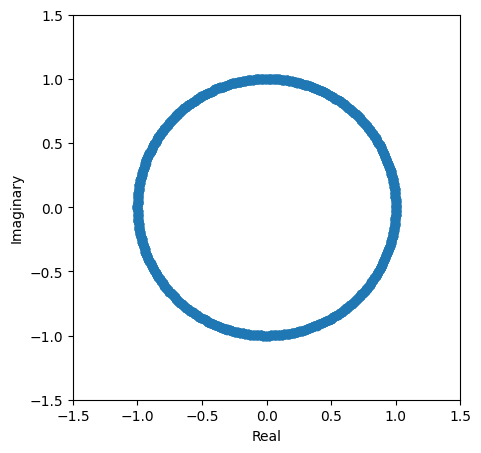

/var/folders/z0/l5jcf2qj14v1x9vwr4fbvtr80000gn/T/ipykernel_3327/2043430019.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  V[:,i] = p_vec


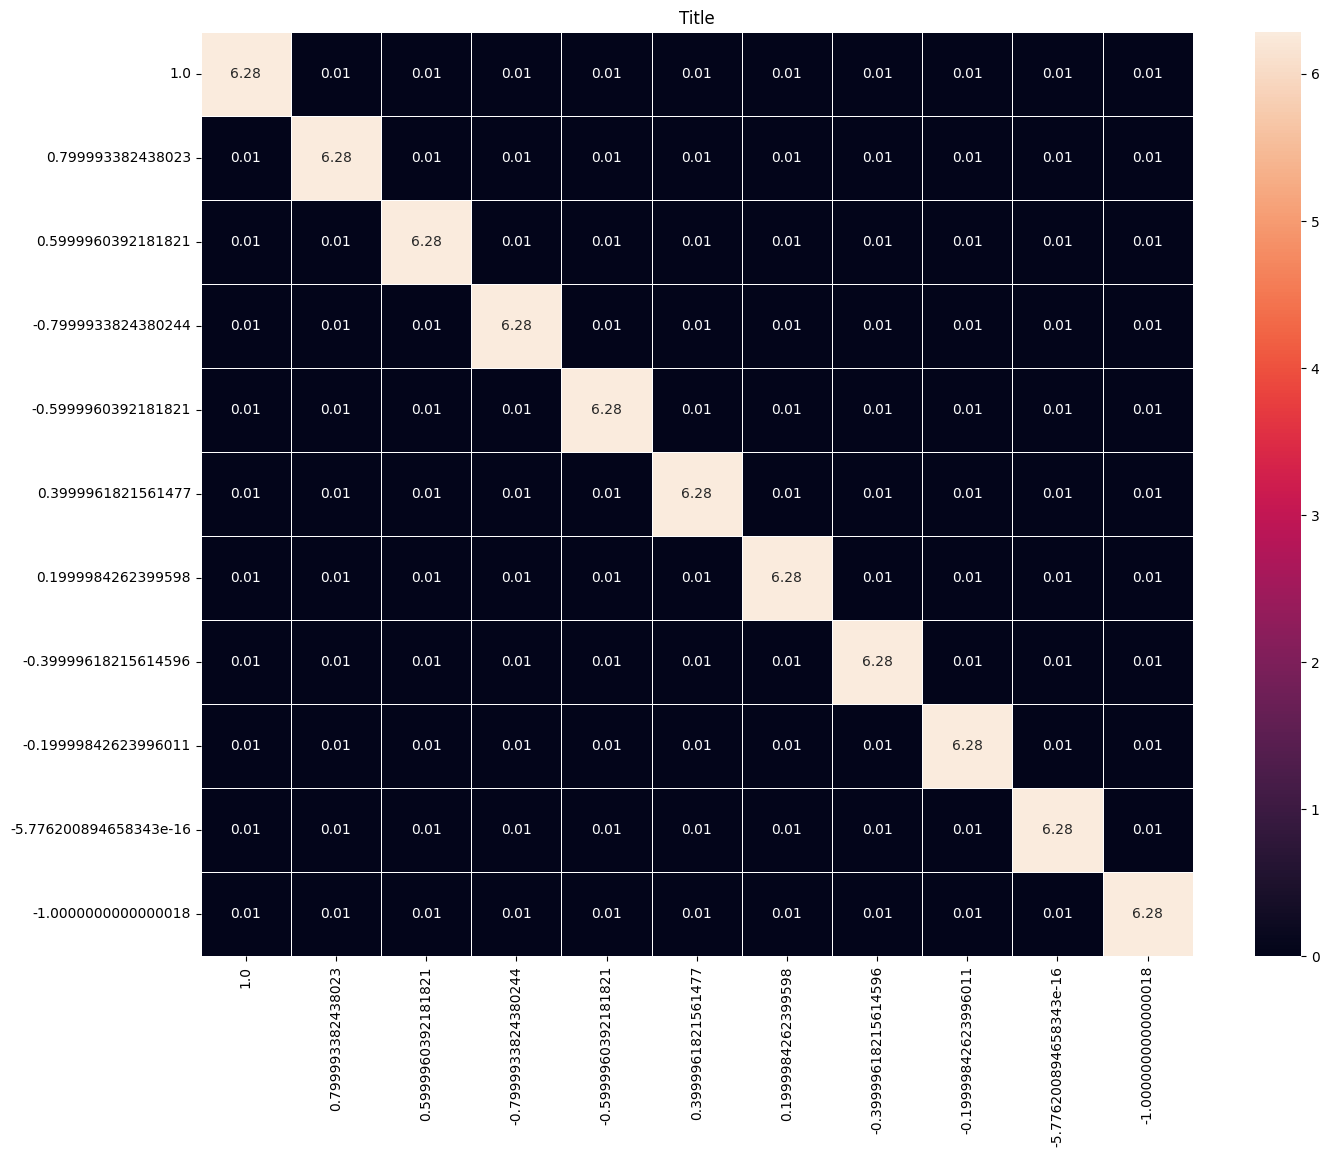

In [3]:
tef = TestEigenfunc()
tef.run()